In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import torch

from ddpm import LatentDiffusionModel, CustomDataset, get_ddpm_scheduler_variables, extract
from tqdm.auto import tqdm

timesteps = 1000
timesteps, betas, alphas, alphas_cumprod, alphas_cumprod_prev, sqrt_recip_alphas, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, posterior_variance = get_ddpm_scheduler_variables(timesteps=timesteps)

device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cuda:6
Diffusion Model parameters: 51956544


### Load Diffusion 

In [ ]:
# 初始化模型
latent_dim = 256
hidden_dims = [2048, 2048, 2048, 2048] 
max_freq = 4  # Example max frequency for Fourier features
num_bands = 4  # Number of frequency bands
scalar_hidden_dims = [256,256,256,256]
diffusion_model = LatentDiffusionModel(latent_dim, hidden_dims, scalar_hidden_dims, max_freq, num_bands).to(device)

diffusion_ckpt_path = "/home/ziran/se3/dev_ckpt/model_epo399999.pth"
diffusion_ckpt = torch.load(diffusion_ckpt_path, map_location=device)
diffusion_model.load_state_dict(diffusion_ckpt['model'])
diffusion_model = diffusion_model.to(device)
print('Diffusion Model parameters:', sum(p.numel() for p in diffusion_model.parameters()))

In [11]:
pred_x_0_list = []
@torch.no_grad()
def uncond_p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    # Note: \grad_{x_t} \log p(x_t|x_0) = - (\epsilon) / (\sqrt{1 - \alpha^{hat}_t})
    #                                   = - model(x, t) / sqrt_one_minus_alphas_cumprod_t
    model_out = model(x, t, timesteps)

    score_x = model_out / sqrt_one_minus_alphas_cumprod_t
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * score_x
    )
    # if t[0]>1:
    #     sqrt_alphas_cumprod_tminus1 = extract(sqrt_alphas_cumprod, t-1, x.shape)
    # else:
    #     sqrt_alphas_cumprod_tminus1 = torch.ones_like(x)
    # pred_x_0 = sqrt_recip_alphas_t * (x - sqrt_one_minus_alphas_cumprod_t * model_out) / sqrt_alphas_cumprod_tminus1
    
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x.shape)
    pred_x_0 = (x - sqrt_one_minus_alphas_cumprod_t * model_out) / sqrt_alphas_cumprod_t
    pred_x_0_list.append(pred_x_0)
    
    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 
        
# Algorithm 2:
@torch.no_grad()
def uncond_p_sample_loop(model, shape, return_traj = False):
    # assert eta in [0, 1]
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    x_t = torch.randn(shape, device=device)
    traj = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        x_t_minus1 = uncond_p_sample(model, x_t, torch.full((b,), i, device=device, dtype=torch.long), i)
        x_t = x_t_minus1
        traj.append(x_t.cpu())
    if return_traj:
        return torch.stack(traj, dim=1)
    else:    
        return x_t

torch.manual_seed(12)
bs = 5
eta = 1.
trajs = uncond_p_sample_loop(model=diffusion_model, shape=(bs, 256, 4), return_traj=True)

### Load Decoder

In [6]:

from EFEM.lib_shape_prior.init import get_AEmodel_cfg
from EFEM.lib_shape_prior.core.models import get_model
category = "mugs"
# category = "kit4cates"
# category = "chairs"
config_Only_model = get_AEmodel_cfg()
ModelClass = get_model(config_Only_model["model"]["model_name"])
model = ModelClass(config_Only_model)
ckpt_path = f"/home/ziran/se3/EFEM/weights/{category}.pt"
ckpt = torch.load(ckpt_path, map_location=device)
model.network.load_state_dict(ckpt['model_state_dict'])
model.network = model.network.to(device)


### Load Codebook Dataset

In [14]:
codebook_path = f"/home/ziran/se3/EFEM/cache/mugs.npz"
train_ds = CustomDataset(codebook_path, normalization = True)

z_so3 (149, 256, 3)
z_inv (149, 256)
center (149, 1, 3)
scale (149,)
z_so3_proj (149, 256, 3)
z_so3_basis (149, 3, 3)
z_so3_var (149, 3)
bbox (149, 3)
bbox_c (149, 3)
pcl (149, 5000, 3)
cls (149,)
========== Data Normalization BEGIN ==========
z_so3_mean tensor(0.0039)
z_so3_std tensor(0.0359)
z_inv_mean tensor(-0.0006)
z_inv_std tensor(0.0132)
========== Data Normalization FINISHED ==========


## Visualization on the Diffusion process over time(predicted x_0)
所谓的predicted x_0就是DDIM paper中的 Equation (12)中的predicted x_0.

use normal params: {'z_so3_mean': tensor(0.0039), 'z_so3_std': tensor(0.0359), 'z_inv_mean': tensor(-0.0006), 'z_inv_std': tensor(0.0132)}
shape:  torch.Size([20, 256, 3]) torch.Size([20, 256]) torch.Size([20]) torch.Size([20, 1, 3])
rows: 4 cols: 5


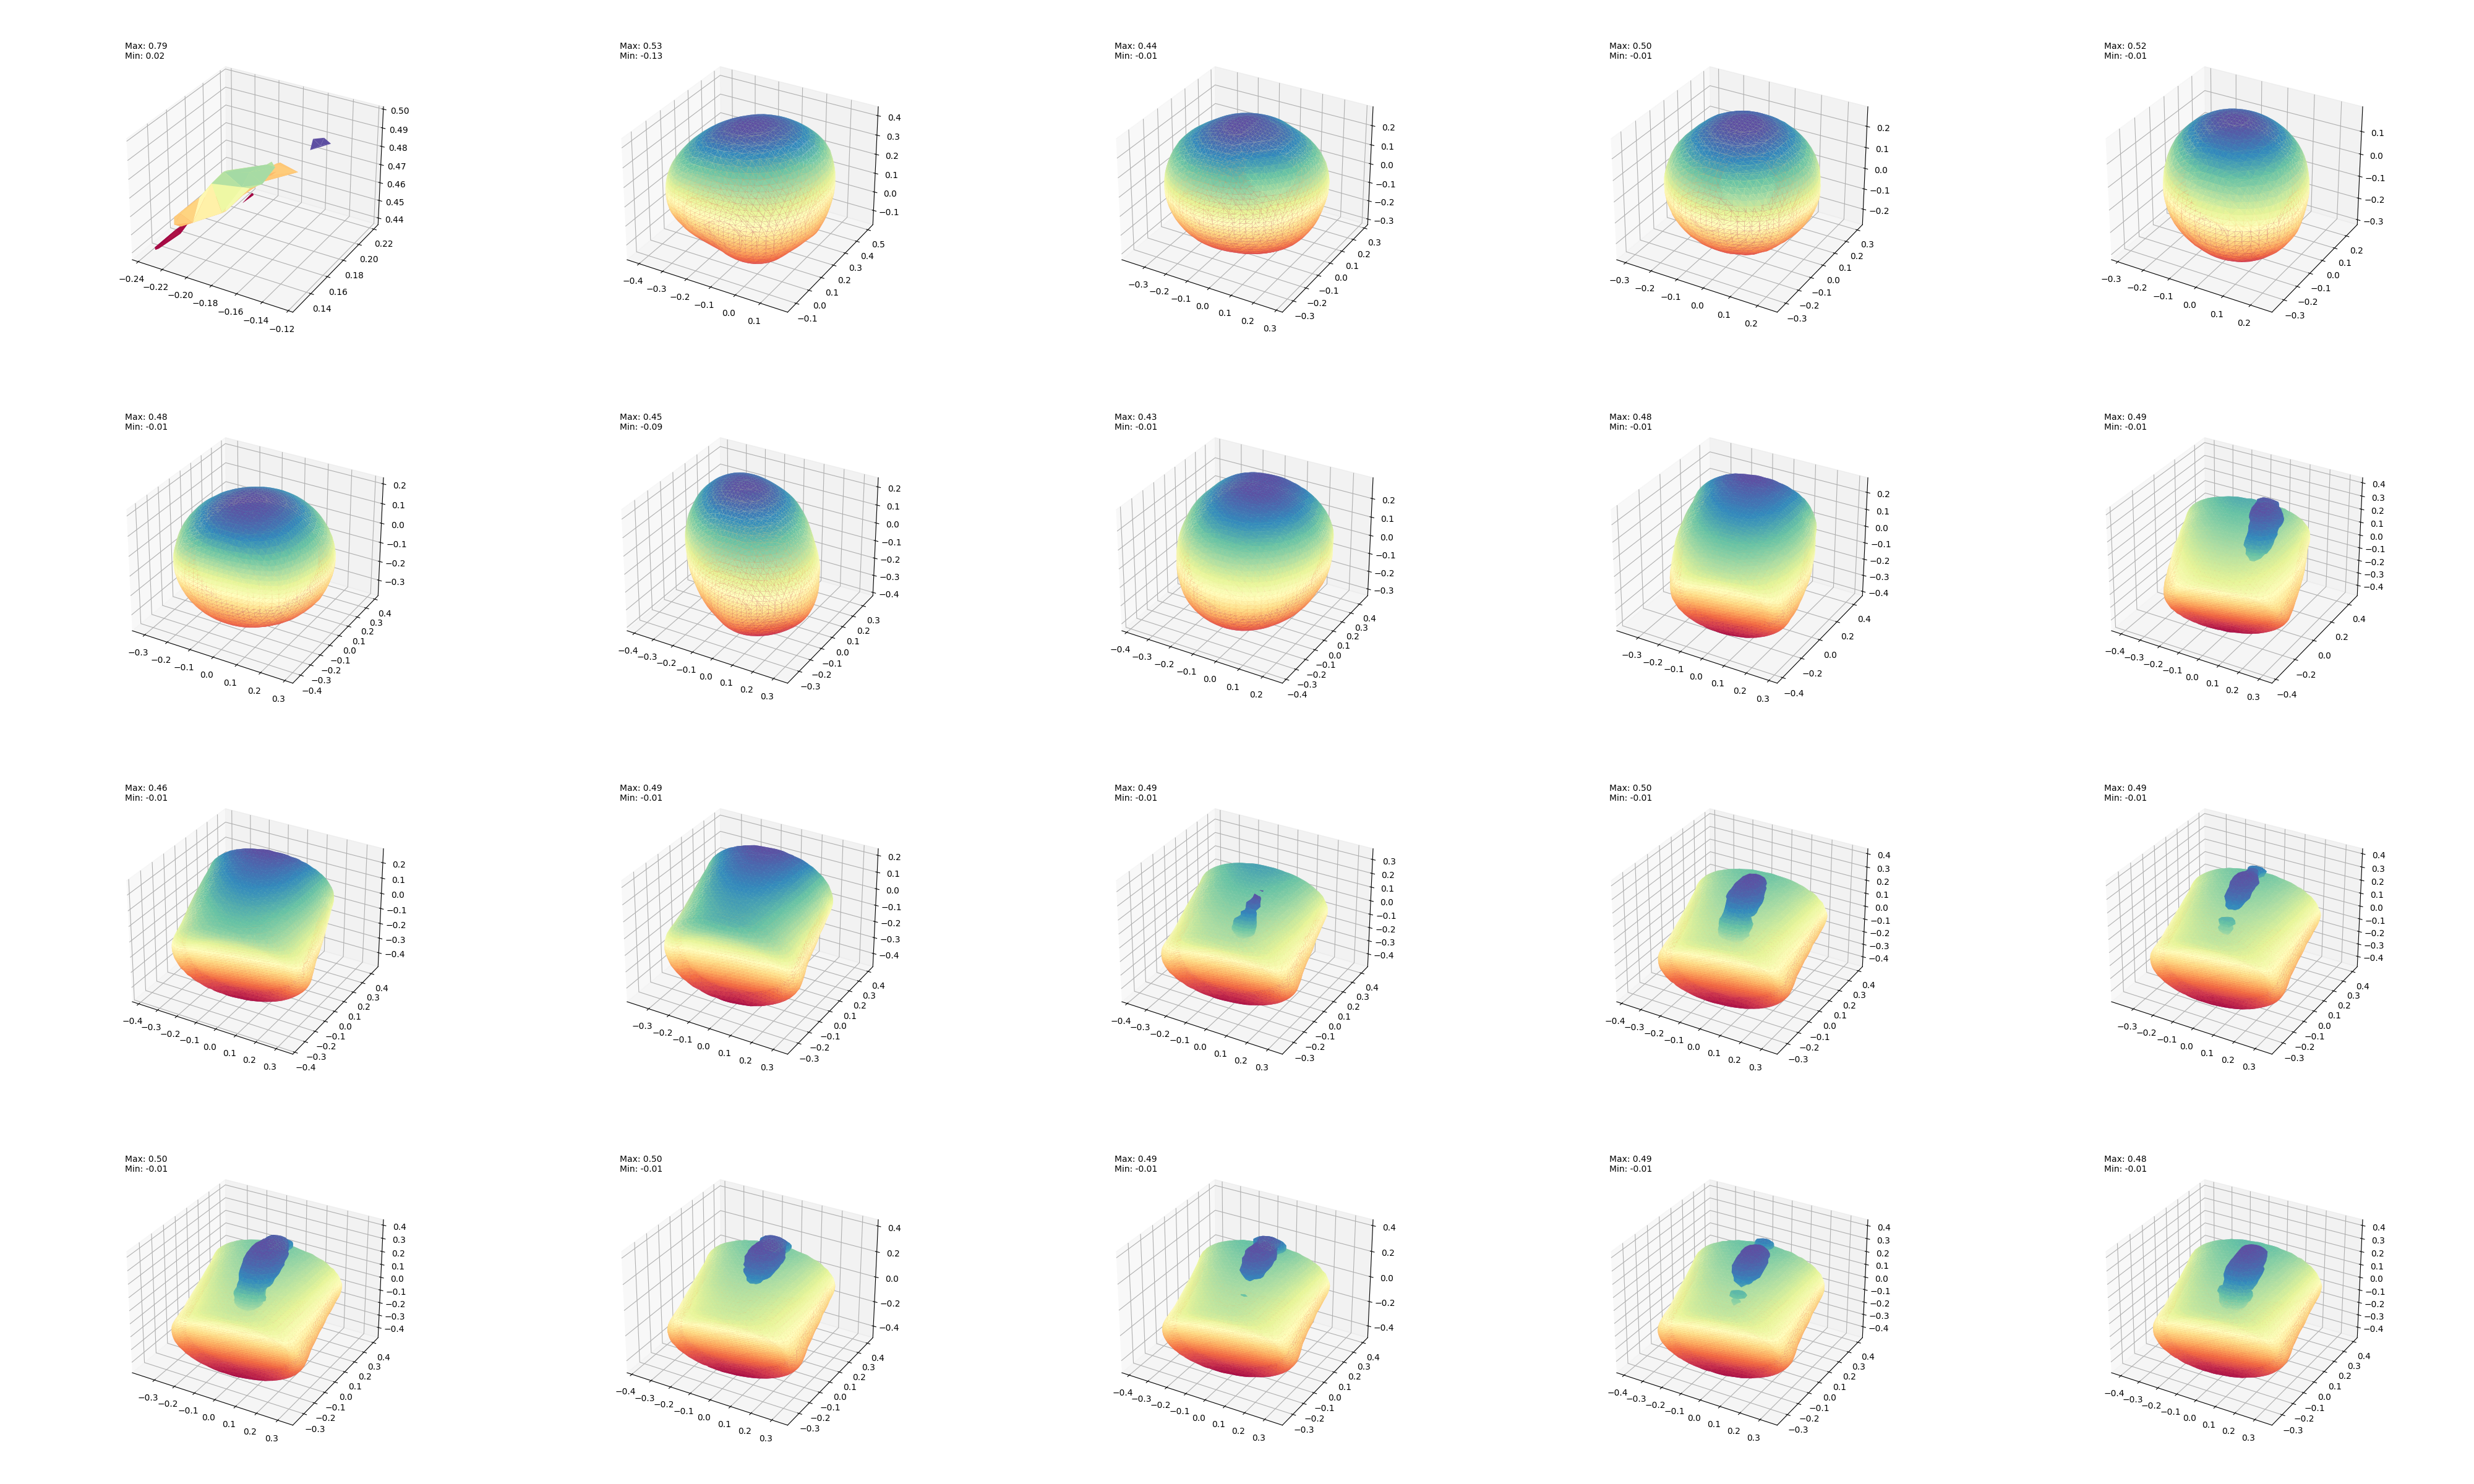

In [ ]:
from viz_x import viz_x, viz_x_img

time_slice = slice(1, 1001, 50)
print(time_slice)
sample_idx = 2
a = torch.stack([item[sample_idx] for item in pred_x_0_list[time_slice]], dim=0)
a.shape

single_images, combined_image = viz_x_img(a, model, device, train_ds.normal_params)
display(combined_image)

## simple viz

In [ ]:
from viz_x import viz_x

viz_x(torch.tensor(trajs[-1]), model, device, train_ds.normal_params)